In [1]:
import torch

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood 
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.kernels.matern_kernel import MaternKernel

from botorch.models.transforms import Normalize, Standardize
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

import numpy as np
import tqdm

%load_ext autoreload
%autoreload 2

import helper_fns
from helper_fns.plotting_utils import plot_objectives, plot_objectives_mean_std, plot_hist_f_rho, plot_f_rho
from helper_fns.reporting_rules_postprocess import transform_x_to_tensor, report_idx_max_ymean, report_idx_max_mv, \
    report_idx_max_last_lcb_rahbo, report_idx_max_last_lcb_rahbous, report_idx_max_last_lcb_ucb

import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [2]:
# Plotting settings

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["animation.html"] = "jshtml"
from matplotlib import animation
from IPython.display import display, HTML
import seaborn as sns
sns.set_style("whitegrid")

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams['font.size'] = 16
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [3]:
# RAHBO imports

import rahbo
from rahbo.test_functions.sine import SineBenchmark
from rahbo.optimization.bo_step import bo_step, bo_step_risk_averse, bo_step_adaptive_risk_averse
from rahbo.acquisition.acquisition import RiskAverseUpperConfidenceBound, LowerConfidenceBound

In [4]:
import pickle
with open('/home/tueilsy-st01/risk-averse-hetero-bo/hpo/pendulum/gpucb/gpucb_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [5]:
results[0]['inputs'][-3]

tensor([ 1.0000e+02,  1.0000e+03,  5.1200e+02,  1.2800e+02,  1.5000e+05,
         2.0000e+02,  6.4000e+01,  1.2800e+02,  3.0000e+00,  3.0000e+00,
         4.0000e+00,  4.0000e+00,  4.0000e+00,  9.4527e-01,  8.5754e-01,
         2.3685e-01,  2.0060e-01,  1.6428e-02, -2.8106e+00, -1.4065e+00,
        -2.0285e+00])

In [6]:
# bo_algos = ['gpucb', 'rahbo']
# bo_algos = ['gpucb']
# experiment = '/home/tueilsy-st01/safe-control-gym/examples/hpo/quadrotor_2D_attitude'
# results = {}
# for bo_algo in bo_algos:
#     # runs = os.listdir(f'{experiment}/{algo}')
#     runs = ['run1']
#     for run in runs:
#         result_path = f'{experiment}/{algo}/{run}/{bo_algo}'
#         with open(f'{result_path}/{bo_algo}_results.pkl', 'rb') as f:
#             results[bo_algo] = pickle.load(f)
# objectives = {'gpucb': results['gpucb'][0]['scores'][results['gpucb'][0]['reporting_idx']] - results['gpucb'][0]['scores_var'][results['gpucb'][0]['reporting_idx']],
#               'rahbo': results['rahbo'][0]['scores'][results['rahbo'][0]['reporting_idx']] - results['rahbo'][0]['scores_var'][results['rahbo'][0]['reporting_idx']],
#               'erahbo': results['erahbo'][0]['scores'][results['erahbo'][0]['reporting_idx']] - results['erahbo'][0]['scores_var'][results['erahbo'][0]['reporting_idx']]}
# plot_objectives(objectives, objective_name='MV($\\hat{x}_T$)', x_label='Evaluations')

In [7]:
algo = 'ppo'
bo_algos = ['gpucb', 'rahbo', 'erahbo']
gamma = 1 # risk adjust parameter
experiment = '/home/tueilsy-st01/risk-averse-hetero-bo/hpo/pendulum'

In [8]:

results = {}
gammas = {}
for bo_algo in bo_algos:
    with open(f'{experiment}/{bo_algo}/{bo_algo}_results.pkl', 'rb') as f:
        results[bo_algo] = pickle.load(f)
    with open(f'{experiment}/{bo_algo}/config.yaml', 'r') as f:
        gammas[bo_algo] = yaml.safe_load(f)['gamma']

In [9]:
results['gpucb'][0]['inputs'][results['gpucb'][0]['reporting_idx']][-1]

tensor([ 1.0000e+02,  1.0000e+03,  1.0240e+03,  1.2800e+02,  3.5000e+05,
         1.0000e+02,  3.2000e+01,  1.2800e+02,  3.0000e+00,  3.0000e+00,
         4.0000e+00,  4.0000e+00,  4.0000e+00,  9.4561e-01,  8.5666e-01,
         2.3385e-01,  2.0096e-01,  1.6024e-02, -2.8325e+00, -1.2863e+00,
        -1.8363e+00])

In [10]:
results['erahbo'][0]['inputs'][results['erahbo'][0]['reporting_idx'][-1]]

tensor([ 1.0000e+03,  1.0000e+03,  1.0240e+03,  2.5600e+02,  4.0000e+05,
         1.0000e+02,  6.4000e+01,  6.4000e+01,  2.0000e+00,  4.0000e+00,
         3.0000e+00,  2.0000e+00,  4.0000e+00,  9.6720e-01,  8.0599e-01,
         3.6770e-01,  6.0268e-01,  8.0670e-03, -3.1464e+00, -1.8035e+00,
        -4.2042e+00])

In [11]:
results['gpucb'][0]['reporting_idx'][-1]

68

In [12]:
results['erahbo'][0]['eval_scores']

tensor([[  -191.4018],
        [ -2748.7560],
        [  -652.7735],
        [-14178.5070],
        [ -2370.2830],
        [  -859.2155],
        [ -1080.3619],
        [  -198.3071],
        [ -1489.9170],
        [ -2911.1980],
        [ -1426.8152],
        [ -1098.8939],
        [  -974.8550],
        [  -619.5192],
        [-10133.6154],
        [ -3137.8110],
        [ -4066.0600],
        [ -2817.5220],
        [  -735.5174],
        [  -804.6376],
        [  -191.8119],
        [  -183.1153],
        [  -183.5546],
        [  -179.4489],
        [  -200.3172],
        [  -207.1133],
        [  -193.8798],
        [  -215.3660],
        [  -224.9055],
        [  -199.5639],
        [  -199.5243],
        [  -224.1028],
        [  -205.1465],
        [  -203.6392],
        [  -187.0556],
        [  -206.8860],
        [  -194.4012],
        [  -206.8468],
        [  -195.7335],
        [  -191.5843],
        [  -291.6923],
        [  -282.3120],
        [  -267.7457],
        [  

In [13]:
results['rahbo'][0]['eval_scores']

tensor([[  -191.4018],
        [ -2748.7560],
        [  -652.7735],
        [-14178.5070],
        [ -2370.2830],
        [  -859.2155],
        [ -1080.3619],
        [  -198.3071],
        [ -1489.9170],
        [ -2911.1980],
        [ -1426.8152],
        [ -1098.8939],
        [  -974.8550],
        [  -619.5192],
        [-10133.6154],
        [ -3137.8110],
        [ -4066.0600],
        [ -2817.5220],
        [  -735.5174],
        [  -804.6376],
        [  -191.8119],
        [  -183.1153],
        [  -183.5546],
        [  -179.4489],
        [  -408.0769],
        [  -446.0649],
        [  -304.2825],
        [  -339.6798],
        [  -262.6266],
        [  -460.2343],
        [  -487.6439],
        [  -300.2927],
        [  -395.1612],
        [  -417.8349],
        [  -206.1669],
        [  -197.0325],
        [  -189.9902],
        [  -168.7323],
        [  -243.5922],
        [  -227.9738],
        [  -219.1162],
        [  -250.3387],
        [  -219.4263],
        [  

In [14]:
results['gpucb'][0]['eval_scores']

tensor([[  -191.4018],
        [ -2748.7560],
        [  -652.7735],
        [-14178.5070],
        [ -2370.2830],
        [  -859.2155],
        [ -1080.3619],
        [  -198.3071],
        [ -1489.9170],
        [ -2911.1980],
        [ -1426.8152],
        [ -1098.8939],
        [  -974.8550],
        [  -619.5192],
        [-10133.6154],
        [ -3137.8110],
        [ -4066.0600],
        [ -2817.5220],
        [  -735.5174],
        [  -804.6376],
        [  -191.8119],
        [  -183.1153],
        [  -183.5546],
        [  -179.4489],
        [  -200.3172],
        [  -207.1133],
        [  -193.8798],
        [  -215.3660],
        [  -224.9055],
        [  -199.5639],
        [  -199.5243],
        [  -224.1028],
        [  -205.1465],
        [  -203.6392],
        [  -187.0556],
        [  -206.8860],
        [  -194.4012],
        [  -206.8468],
        [  -195.7335],
        [  -191.5843],
        [  -184.5572],
        [  -196.4354],
        [  -186.9108],
        [  

In [15]:
torch.cat([results['gpucb'][i]['scores'][results['gpucb'][i]['reporting_idx']] for i in range(len(results['gpucb']))], dim=1).shape

torch.Size([500, 10])

In [16]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']][:min_shape] - gamma * results[bo_algo][i]['scores_var'][results[bo_algo][i]['reporting_idx']][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']] - gamma * results[bo_algo][i]['scores_var'][results[bo_algo][i]['reporting_idx']] for i in range(len(results[bo_algo]))], dim=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='Evaluations', ylabel='MV($\\hat{x}_T$)'>)

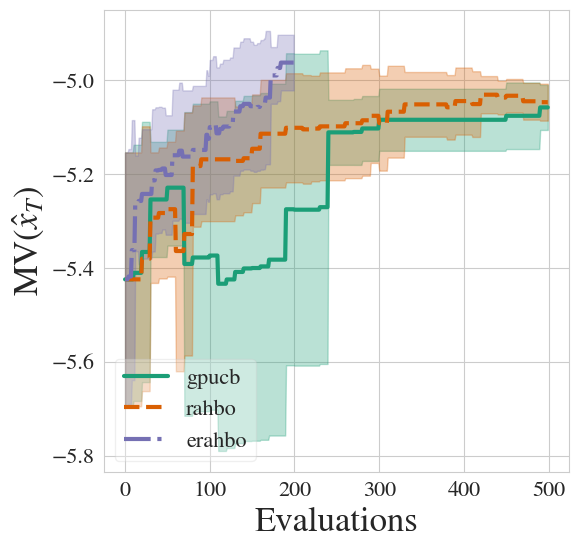

In [17]:
plot_objectives_mean_std(objectives, objective_name='MV($\\hat{x}_T$)', x_label='Evaluations')

In [18]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']] for i in range(len(results[bo_algo]))], dim=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='Evaluations', ylabel='f($\\hat{x}_T$)'>)

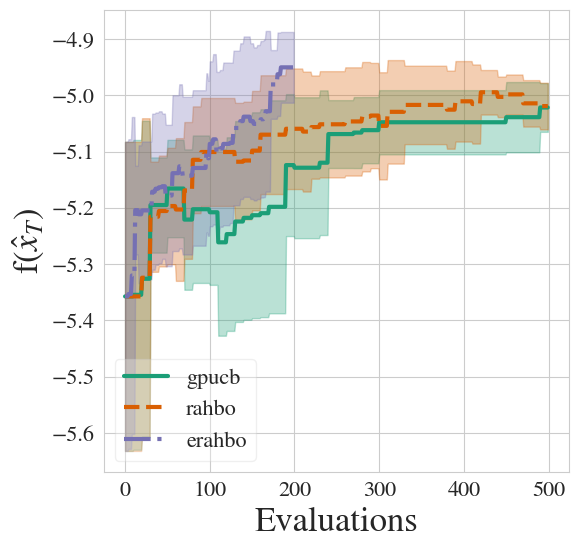

In [19]:
plot_objectives_mean_std(objectives, objective_name='f($\\hat{x}_T$)', x_label='Evaluations')

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='BO Iterations', ylabel='MV($\\hat{x}_T$)'>)

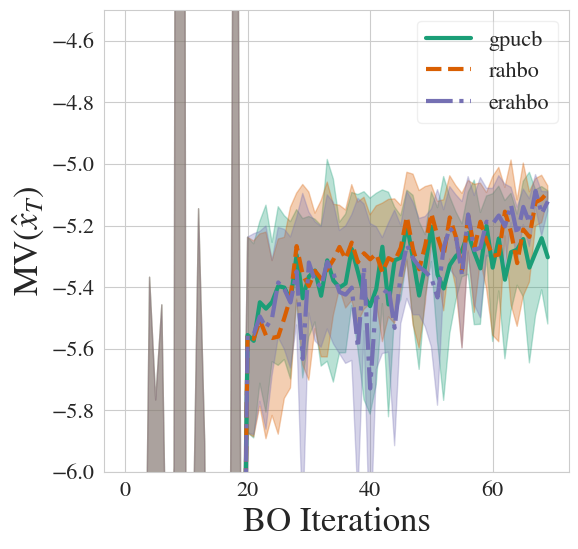

In [35]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['eval_scaled_y'].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scaled_y'][:min_shape] - gamma * results[bo_algo][i]['eval_scaled_y_var'][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scaled_y'] - gamma * results[bo_algo][i]['eval_scaled_y_var'] for i in range(len(results[bo_algo]))], dim=1)

plot_objectives_mean_std(objectives, objective_name='MV($\\hat{x}_T$)', x_label='BO Iterations', ylim=[-6, -4.5])

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='BO Iterations', ylabel='f($\\hat{x}_T$)'>)

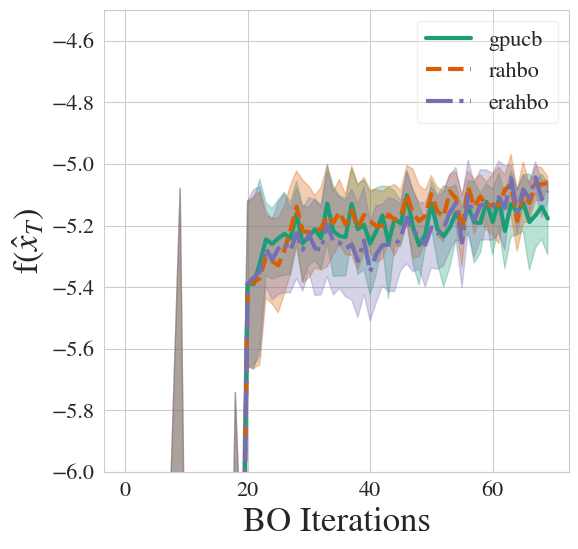

In [38]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['eval_scaled_y'].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scaled_y'][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scaled_y'] for i in range(len(results[bo_algo]))], dim=1)
plot_objectives_mean_std(objectives, objective_name='f($\\hat{x}_T$)', x_label='BO Iterations', ylim=[-6, -4.5])

In [28]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['eval_scores'].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scores'][:min_shape] - gamma * results[bo_algo][i]['eval_scores_var'][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scores'] - gamma * results[bo_algo][i]['eval_scores_var'] for i in range(len(results[bo_algo]))], dim=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='BO Iterations', ylabel='MV($\\hat{x}_T$)'>)

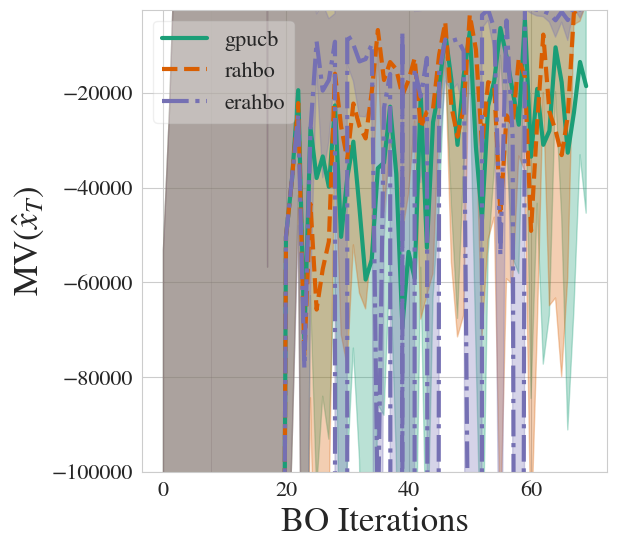

In [29]:
plot_objectives_mean_std(objectives, objective_name='MV($\\hat{x}_T$)', x_label='BO Iterations', ylim=[-100000, -2500])

In [36]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['eval_scores'].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scores'][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scores'] for i in range(len(results[bo_algo]))], dim=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='BO Iterations', ylabel='f($\\hat{x}_T$)'>)

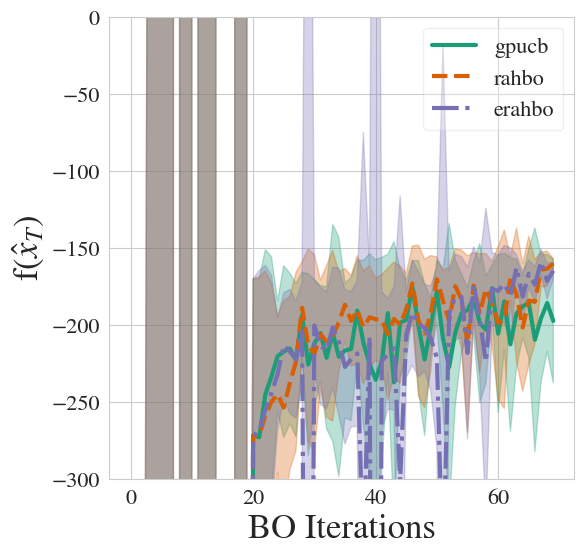

In [37]:
plot_objectives_mean_std(objectives, objective_name='f($\\hat{x}_T$)', x_label='BO Iterations', ylim=[-300, 0])